In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(2) # gpu idx

In [2]:
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import ZeroPadding3D, Input, Dense, Flatten, BatchNormalization,MaxPool3D, Activation, Dropout
from keras.layers.convolutional import Conv3D
from keras import optimizers
from keras.optimizers import Adam, SGD
import keras
from keras import backend as K
import keras_video.utils

Using TensorFlow backend.


In [3]:
import keras_video
import glob
classes = [i.split(os.path.sep)[1] for i in glob.glob('train_video/*')]
glob_pattern='train_video/{classname}/*.webm'

In [4]:
data_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=2)
    #width_shift_range=.2,
    #height_shift_range=.2)
train = keras_video.VideoFrameGenerator(classes=classes, glob_pattern=glob_pattern, nb_frames=16, batch_size=15, target_shape=(112, 112), split_val=0.2, transformation=data_aug, shuffle=True)

class attach, validation count: 167, train count: 669
class close, validation count: 212, train count: 851
class cover, validation count: 544, train count: 2179
class drop, validation count: 223, train count: 894
class fold, validation count: 194, train count: 777
class hold, validation count: 281, train count: 1125
class move, validation count: 630, train count: 2523
class put, validation count: 654, train count: 2620
class take, validation count: 339, train count: 1360
class throw, validation count: 448, train count: 1796
Total data: 10 classes for 14794 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 10 classes for 3692 files for validation


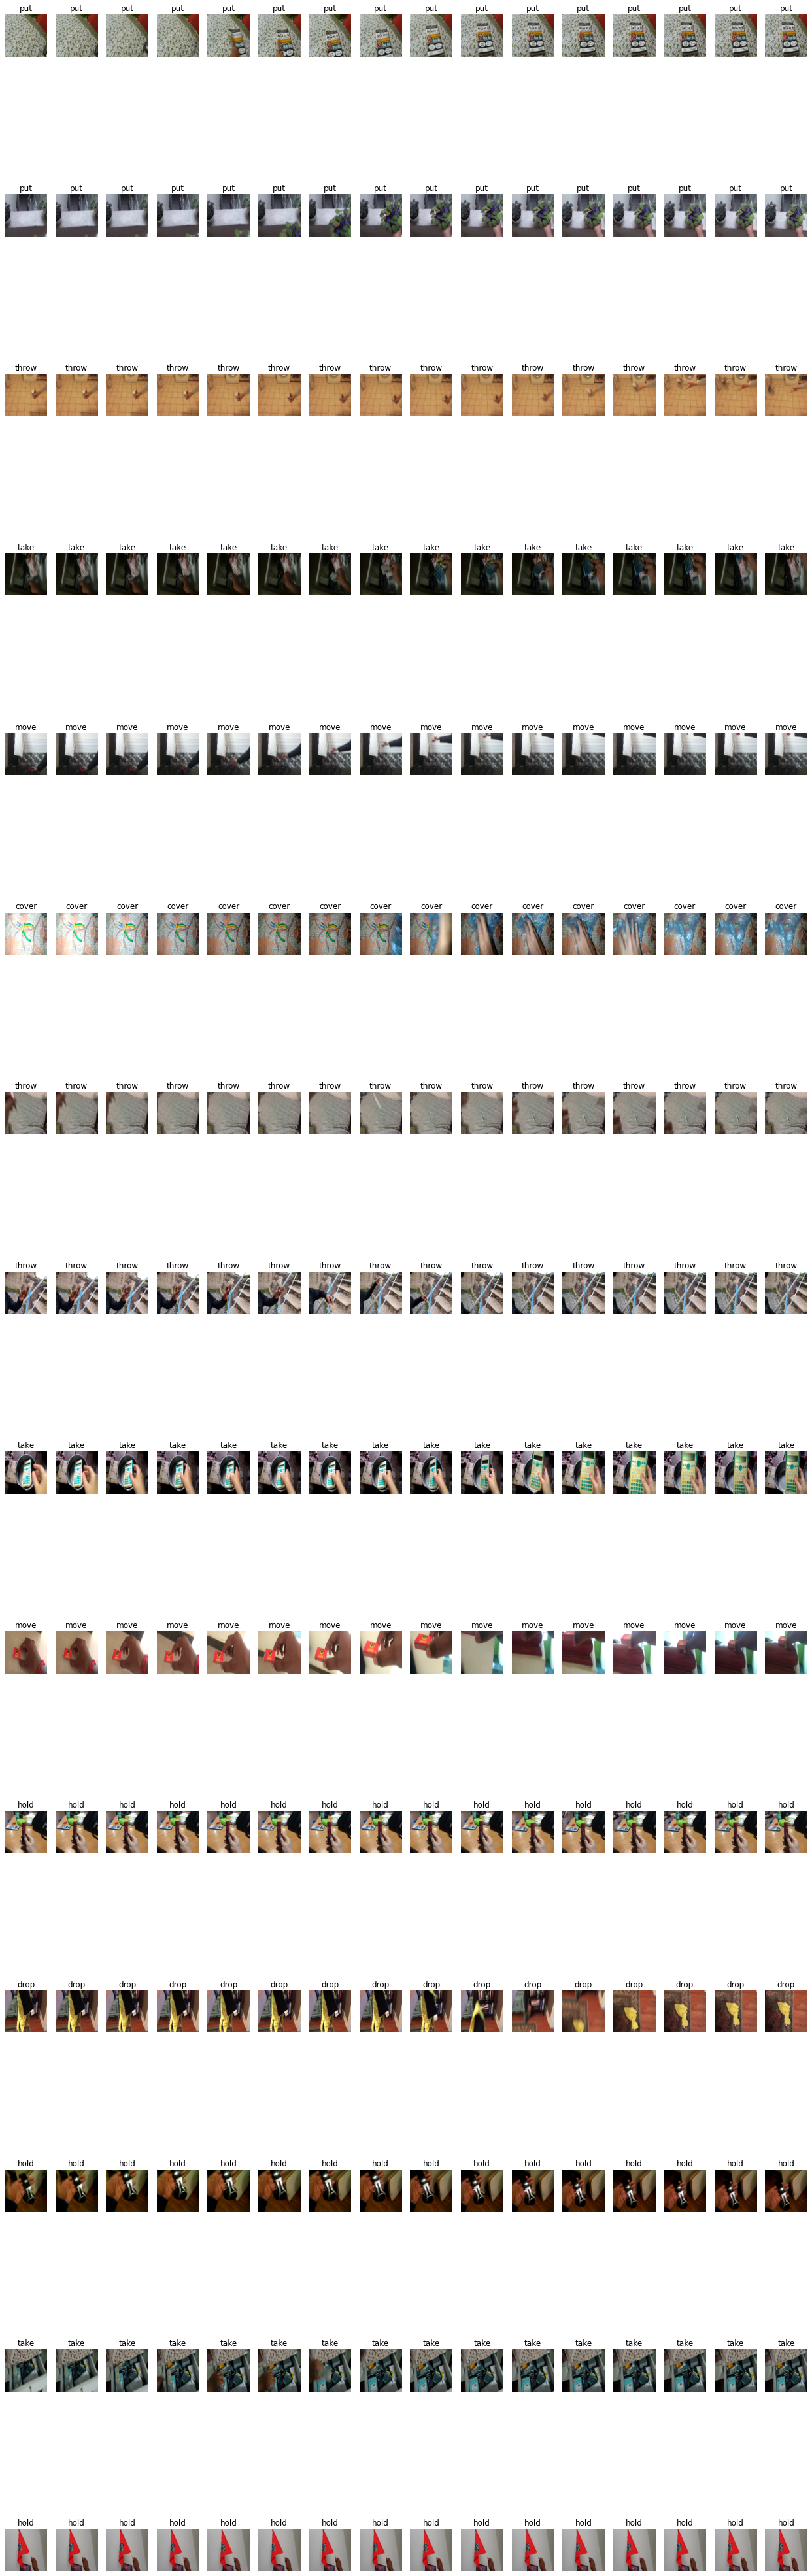

In [6]:
keras_video.utils.show_sample(train, random=True)

In [8]:
## input layer
input_layer = Input((16, 112, 112, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(input_layer)
pooling_layer1 = MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid')(conv_layer1)

conv_layer2 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(pooling_layer1)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(conv_layer2)

## add max pooling to obtain the most imformatic features

conv_layer3 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(pooling_layer2)
conv_layer4 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(conv_layer3)
pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='valid')(conv_layer4)

conv_layer5 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(pooling_layer3)
conv_layer6 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(conv_layer5)
pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(conv_layer6)
conv_layer7 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(pooling_layer4)
conv_layer8 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1))(conv_layer7)
pooling_layer5 = ZeroPadding3D(padding=(0, 1, 1))(conv_layer8)
## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer6 = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(pooling_layer5)
pooling_layer6 = BatchNormalization()(pooling_layer6)
flatten_layer = Flatten()(pooling_layer6)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(units=4096, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
optimizer = Adam(learning_rate=2e-5)
#optimizer = SGD(learning_rate=0.003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 112, 112, 3)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 8, 28, 28, 256)    1769

In [10]:
EPOCHS=30

callbacks = [
    #keras.callbacks.ReduceLROnPlateau(verbose=1),#측정 항목이 향상되지 않는 경우 learning rate 줄임
    keras.callbacks.ModelCheckpoint(
        '/home/jiho/work/repos/somth2smth_conv3d/model/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
    keras.callbacks.TensorBoard(log_dir='/home/jiho/work/repos/somth2smth_conv3d')#그래프로 보기위해 기록 저장
]
model.fit_generator(
    train,
    validation_data=valid,
    steps_per_epoch=4000/15, 
    validation_steps=1000/15, 
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
267/266 [==============================] - 328s 1s/step - loss: 2.1650 - accuracy: 0.1908 - val_loss: 2.2289 - val_accuracy: 0.2557

Epoch 00001: saving model to /home/jiho/work/repos/somth2smth_conv3d/model/weights.01-2.23.hdf5
Epoch 2/30
267/266 [==============================] - 318s 1s/step - loss: 2.0284 - accuracy: 0.2597 - val_loss: 1.9627 - val_accuracy: 0.3602

Epoch 00002: saving model to /home/jiho/work/repos/somth2smth_conv3d/model/weights.02-1.96.hdf5
Epoch 3/30
267/266 [==============================] - 318s 1s/step - loss: 1.8826 - accuracy: 0.3620 - val_loss: 1.5293 - val_accuracy: 0.4040

Epoch 00003: saving model to /home/jiho/work/repos/somth2smth_conv3d/model/weights.03-1.53.hdf5
Epoch 4/30
267/266 [==============================] - 259s 970ms/step - loss: 1.7593 - accuracy: 0.4002 - val_loss: 2.2266 - val_accuracy: 0.4139

Epoch 00004: saving model to /home/jiho/work/repos/somth2smth_conv3d/model/weights.04